# This notebook contains exploratory code for different models. 
The goal is to be able to run captioning on 2 images with each model.

# Setup

In [1]:
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from transformers import AutoProcessor, AutoModelForCausalLM
from transformers import LlavaProcessor, LlavaForConditionalGeneration
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from transformers import InstructBlipProcessor, InstructBlipForConditionalGeneration

from IPython.display import display
from PIL import Image

def resize_to_max_width(image: Image.Image, max_width: int) -> Image.Image:
    """
    Resize an image to a given max width while preserving aspect ratio.
    If the image width is already less than or equal to max_width, it's returned unchanged.
    """
    width, height = image.size
    if width <= max_width:
        return image

    # Calculate new height to maintain aspect ratio
    new_height = int((max_width / width) * height)
    resized_image = image.resize((max_width, new_height), Image.Resampling.LANCZOS)
    return resized_image

def pretty_int(n: int) -> str:
    return f"{n:,}"

def pretty_float(n: float) -> str:
    return f"{n:.2f}"

def model_spec(model) -> str: 
    params, size = estimate_model_size(model[1])
    print(f"""
Params: {pretty_int(params)}
Size:   {pretty_float(size)}MB
    """)

def estimate_model_size(model):
    dtype_sizes = {
        torch.float32: 4,
        torch.float16: 2,
        torch.bfloat16: 2,
        torch.int8: 1,
        torch.int16: 2,
        torch.int32: 4,
        torch.int64: 8,
        torch.bool: 1
    }

    total_params = 0
    total_bytes = 0

    for param in model.parameters():
        param_size = param.numel()
        param_dtype = param.dtype
        bytes_per_elem = dtype_sizes.get(param_dtype, 4)  # fallback to 4 bytes
        total_params += param_size
        total_bytes += param_size * bytes_per_elem

    total_size_mb = total_bytes / (1024 ** 2)
    return total_params, total_size_mb

# BLIP Instruct

In [3]:
model_spec(InstructBlipModelLoader.get_instance())

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


Params: 4,022,969,088
Size:   8633.25MB
    


In [2]:
class InstructBlipModelLoader:
    _instance = None

    @staticmethod
    def get_instance():
        if not InstructBlipModelLoader._instance:
            processor = InstructBlipProcessor.from_pretrained("Salesforce/instructblip-flan-t5-xl")
            model = InstructBlipForConditionalGeneration.from_pretrained(
                "Salesforce/instructblip-flan-t5-xl",
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
            )
            model.eval()
            if torch.cuda.is_available():
                model.to("cuda")
            InstructBlipModelLoader._instance = (processor, model)
        return InstructBlipModelLoader._instance

def instructblip_generate_caption(image_path, question="What is in the image?"):
    processor, model = InstructBlipModelLoader.get_instance()
    image = Image.open(image_path).convert("RGB")

    display(resize_to_max_width(image, 400))

    inputs = processor(images=image, text=question, return_tensors="pt").to(model.device)
    generated_ids = model.generate(**inputs)
    answer = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return answer


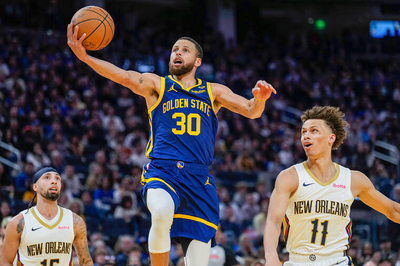

'The image shows a basketball player going up for a shot while other players are watching.'

In [4]:
instructblip_generate_caption("images/basketball.jpg")

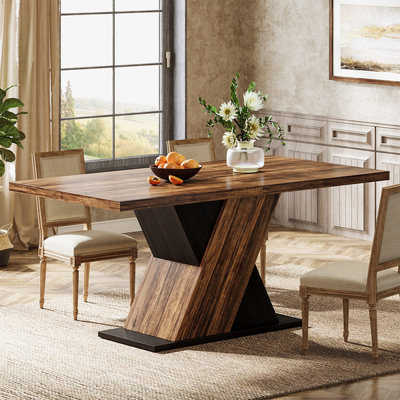

'The image features a dining table with a wooden top and four chairs.'

In [5]:
instructblip_generate_caption("images/dinner-table.jpg")

# BLIP 2

In [11]:
model_spec(Blip2ModelLoader.get_instance())


Params: 3,744,761,856
Size:   7343.15MB
    


In [12]:
class Blip2ModelLoader:
    _instance = None

    @staticmethod
    def get_instance():
        if not Blip2ModelLoader._instance:
            processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
            model = Blip2ForConditionalGeneration.from_pretrained(
                "Salesforce/blip2-opt-2.7b",
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
            )
            model.eval()
            if torch.cuda.is_available():
                model.to("cuda")
            Blip2ModelLoader._instance = (processor, model)
        return Blip2ModelLoader._instance

def blip2_generate_caption(image_path):
    processor, model = Blip2ModelLoader.get_instance()
    image = Image.open(image_path).convert("RGB")

    display(resize_to_max_width(image, 400))

    inputs = processor(images=image, return_tensors="pt").to(model.device)
    generated_ids = model.generate(**inputs)
    caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return caption

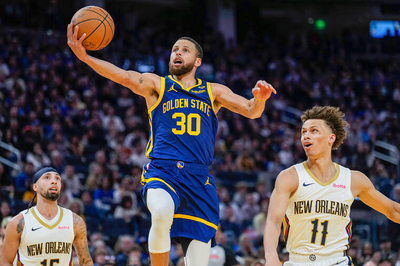

stephen curry, new orleans pelicans



In [8]:
print(blip2_generate_caption("images/basketball.jpg"))

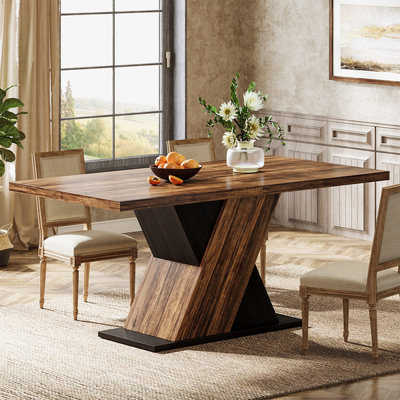

a modern dining table with a wooden base



In [9]:
print(blip2_generate_caption("images/dinner-table.jpg"))

# BLIP Base

In [40]:
model_spec(BlipModelLoader.get_instance())


Params: 247,414,076
Size:   943.81MB
    


In [4]:
class BlipModelLoader:
    _instance = None

    @staticmethod
    def get_instance():
        if not BlipModelLoader._instance:
            processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
            model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
            model.eval()
            if torch.cuda.is_available():
                model.to("cuda")
            BlipModelLoader._instance = (processor, model)
        return BlipModelLoader._instance

def blip_generate_caption(image_path):
    processor, model = BlipModelLoader.get_instance()
    image = Image.open(image_path).convert('RGB')
    
    max_size = 400
    image.thumbnail((max_size, max_size), Image.Resampling.LANCZOS)

    display(image)
    
    full_image = Image.open(image_path).convert('RGB')
    inputs = processor(images=full_image, return_tensors="pt").to(model.device)
    output = model.generate(**inputs)
    caption = processor.decode(output[0], skip_special_tokens=True)

    return caption

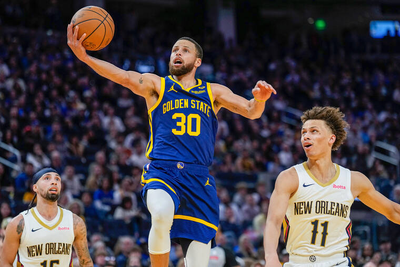

'a man in a blue uniform is shooting a basketball ball'

In [27]:
blip_generate_caption("images/basketball.jpg")

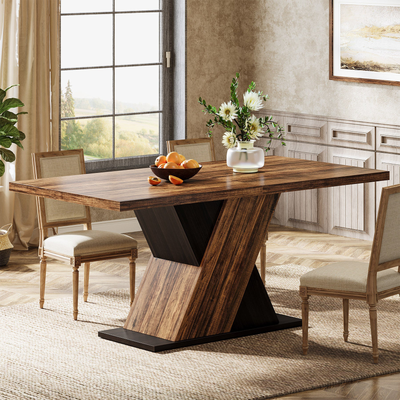

'a dining table with a bowl of fruit on it'

In [28]:
blip_generate_caption("images/dinner-table.jpg")

# Llava 1.5 7B

In [3]:
model_spec(LlavaModelLoader.get_instance())

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


Params: 7,063,427,072
Size:   26944.84MB
    


In [2]:
class LlavaModelLoader:
    _instance = None

    @staticmethod
    def get_instance():
        if not LlavaModelLoader._instance:
            processor = LlavaProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf", use_fast=True)
            model = LlavaForConditionalGeneration.from_pretrained(
                "llava-hf/llava-1.5-7b-hf"
            )

            # GPU poor, can't load the model :/
            #if torch.cuda.is_available():
            #    model.to("cuda")
            
            LlavaModelLoader._instance = (processor, model)
        return LlavaModelLoader._instance

    
def llava_generate_caption(image_path):
    processor, model = LlavaModelLoader.get_instance()

    # Display resized image
    image = Image.open(image_path).convert('RGB')
    image.thumbnail((400, 400), Image.Resampling.LANCZOS)
    display(image)

    # Use full image for captioning
    full_image = Image.open(image_path).convert('RGB')
    full_image =resize_to_max_width(full_image, 400)

    prompt = "<image>\nDescribe the image in detail."

    inputs = processor(full_image, prompt, return_tensors="pt").to(model.device)
    output = model.generate(**inputs, max_new_tokens=100)

    caption = processor.decode(output[0], skip_special_tokens=True)
    return caption

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

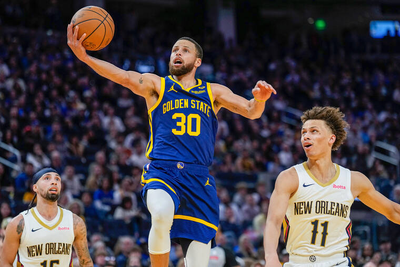


Describe the image in detail.

The image captures a thrilling moment during a basketball game. A man is in the air, holding a basketball, and appears to be about to dunk it. The scene is filled with excitement as the basketball player is the main focus of the image.

There are several other people in the scene, likely teammates and opponents, watching the action unfold. Some of them are standing closer to the foreground, while others are further back in the scene. The atmosphere


In [5]:
print(llava_generate_caption("images/basketball.jpg"))

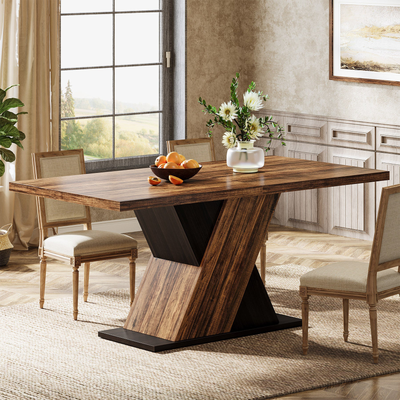


Describe the image in detail.

The image features a large wooden dining table with a centerpiece of a vase filled with flowers. The table is surrounded by several chairs, with some placed on the left side and others on the right side. The chairs are arranged in a semi-circle around the table, creating a comfortable and inviting atmosphere for dining. The table is situated in a living room, with a potted plant placed nearby, adding a touch of greenery to the space.


In [6]:
print(llava_generate_caption("images/dinner-table.jpg"))

# MS GIT Base

In [3]:
model_spec(MsGitModelLoader.get_instance())

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



Params: 176,619,066
Size:   673.75MB
    


In [1]:
class MsGitModelLoader:
    _instance = None

    @staticmethod
    def get_instance():
        if not MsGitModelLoader._instance:
            processor = AutoProcessor.from_pretrained("microsoft/git-base")
            model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

            if torch.cuda.is_available():
                model.to("cuda")
            MsGitModelLoader._instance = (processor, model)
        return MsGitModelLoader._instance

def ms_git_generate_caption(image_path):
    processor, model = MsGitModelLoader.get_instance()
    image = Image.open(image_path).convert('RGB')
    
    max_size = 400
    image.thumbnail((max_size, max_size), Image.Resampling.LANCZOS)

    display(image)
    
    full_image = Image.open(image_path).convert('RGB')
    pixel_values = processor(images=image, return_tensors="pt").pixel_values

    if torch.cuda.is_available():
        pixel_values = pixel_values.to("cuda")

    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return caption

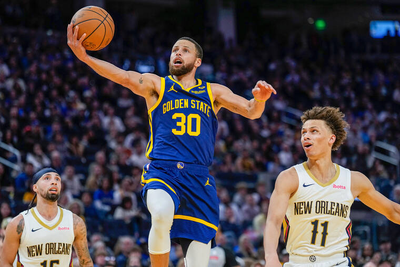

'basketball player drives to the basket during the first half of a basketball game against sports team'

In [41]:
ms_git_generate_caption("images/basketball.jpg")

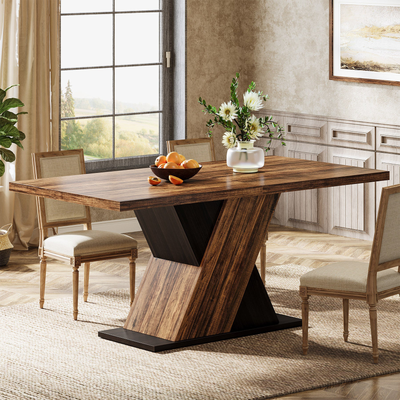

'a brown wooden table'

In [42]:
ms_git_generate_caption("images/dinner-table.jpg")

# Mini GPT-4

In [2]:
# TODO: Make it work with the minigpt4 package
import torch
from transformers import AutoTokenizer
from minigpt4.models import load_model_and_preprocess

class MiniGPT4ModelLoader:
    _instance = None

    @staticmethod
    def get_instance():
        if MiniGPT4ModelLoader._instance is None:
            # Load model and processor
            model, vis_processor, tokenizer = load_model_and_preprocess(
                model_name='minigpt4',
                model_type='vicuna',
                is_eval=True,
                device='cuda' if torch.cuda.is_available() else 'cpu'
            )
            MiniGPT4ModelLoader._instance = (model, vis_processor, tokenizer)
        return MiniGPT4ModelLoader._instance

ModuleNotFoundError: No module named 'minigpt4'